# Calder Lenhart
## ASTRON 3350 Final Project - Computational Notebook


#### Project Description
In this computational notebook, I analyze the line profiles of atomic species in KELT-20b's transmission spectrum. I've integrated this project with my research outside of class.

My workflow thus far has been:
1. Import the spectral data
2. Correct of sources of noise in the data
3. Generate model spectra for atomic species in the atmosphere.
4. Cross-correlate observed spectra with model spectra for all potential atomic/molecular species in the atmosphere -- noting tentative or definite detections (4-sigma and 5-sigma respectively).
5. Correct for the Rossiter-McLaughlin effect.
6. __For detected species, analyze their variations within the atmosphere over the course of transit.__

I've worked on the first five steps previously, although the fifth step is still in progress. The last step is what I intend to do for this final project, doing exploratory data analysis on the line profiles of detected species within the atmosphere. These line profiles are roughly gaussian curves, and I intend to apply a gaussian and/or multi-gaussian fit to them to analyze important properties such as their mean (wind velocity), standard deviation (broadening), amplitude (can correspond to the mechanism in the atmosphere causing them), FWHM, residuals, etc. Using plots of SNR (of the cross-correlations between model and observed spectra) vs phase and residuals (between phase curve and fit) vs phase, I can gather a wealth of information about the underlying dynamics of the atmosphere. This work is essential to my research, and I believe that tying it all in with this class would be perfect, as most of the techniques and analysis we have learned in this class will directly apply. Additionally, many of these visualizations can be employed when presenting my poster at the AAS meeting in January.

__Goals__
1. Generate line profiles + residuals for all species that I've detected and tentatively detected thus far
2. Make gaussian or multi-gaussian fits for each species
3. Analyze the derived parameters, describe all important takeaways for each species, investigate any unexpected outcomes
4. Investigate and quantitatively conclude which mechanisms are behind the wind velocities for each species, using Savel et al. as a reference [1].

__Data__
- Spectra of KELT-20/KELT-20b obtained by PEPSI on LBT
- Model spectra generated by petitRADTRANS

__References__
[1] Savel, A. B., Kempton, E. M. R., Rauscher, E., Komacek, T. D., Bean, J. L., Malik, M., & Malsky, I. (2023). Diagnosing Limb Asymmetries in Hot and Ultrahot Jupiters with High-resolution Transmission Spectroscopy. The Astrophysical Journal, 944(1), 99.


# Generate line profiles + residuals for all species detected and tentatively detected thus far

#### Imports
First, I have to import a bunch of packages necessary to run these precursor functions. Please note that this project is based off some prewritten code for research. My project will largely concern the exploratory data anaylsis aspect of the research. I will submit all of the modules alongside this Jupyter Notebook.

In [23]:
# Imports
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.gridspec as gridspec

from glob import glob
from astropy.io import fits

from scipy.stats import chisquare
from scipy.optimize import curve_fit

from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u
from astropy.table import Table

from uncertainties import ufloat
from uncertainties import unumpy as unp

#from atmo_utilities import ccf, one_log_likelihood, log_likelihood_CCF, vacuum2air, log_likelihood_opt_beta
import time

from dtutils import psarr

#from radiant import generate_atmospheric_model, get_wavelength_range

#from create_model import create_model, instantiate_radtrans
import horus

from run_all_ccfs import *

%matplotlib inline

FileNotFoundError: /Volumes/sabrent/petitRADTRANS_data/input_data/stellar_specs/stellar_params.dat not found.

First, I'll define a gaussian function to fit to the line profile.

In [ ]:
def gaussian(x, a, mu, sigma):

    '''
    Inputs:
    x: x values
    a: amplitude
    mu: mean
    sigma: standard deviation

    Output:
    Gaussian function
    '''
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))


### Preexisting Cross-Correlation Function Plot

I've imported a png of the CCF plot for neutral iron (Fe) in KELT-20b's atmosphere with both the red and blue arms of the PEPSI spectrograph combined. The x-axis is the velocity shift in km/s, and the y-axis is the SNR of the cross-correlation. The peak of the cross-correlation function is the velocity shift of the line profile. The SNR is a measure of the significance of the detection. The higher the SNR, the more significant the detection. The SNR is calculated as the peak of the cross-correlation function divided by the standard deviation of the cross-correlation function.

To anaylze the line profile at the peak of the cross-correlation function, I first fit the Gaussian to each Kp slice (horizontal slice) of the CCF plot. Then, I have an option to pick the Kp slice in two different ways. I can either pick the Kp that corresponds to the expected Kp or the Kp that corresponds to the peak of the cross-correlation function. I will use the latter method for this project. Then, using scipy's curve_fit function, I fit a Gaussian to the line profile. I then plot the line profile and the residuals of the fit. The below code block completes these steps.

<img src="plots/KELT-20b.20190504.combined.Fe.CCFs-shifted-1.png" width="500" height="500">


Here's the explicit logic for the function: 
- Initialization:
    - Check if the spectrograph arm is either 'red' or 'blue'.
    - Initialize empty lists to store fitting parameters (amplitudes, centers, sigmas) and their respective errors.
    - Prepare arrays for storing SNR data slices and their peak values.
- Gaussian Fitting Loop:
    - Iterate over each SNR data slice (from the plotsnr array).
    - Append the current slice and its peak value to Kp_slices and Kp_slice_peak lists.
    - Fit a Gaussian to the current slice using curve_fit, initializing with parameters [5, -7, 1].
    - Store the fitting parameters and their standard deviations (errors) in their respective lists.
- Selecting a Specific Kp Slice:
    - Identify the index of the Kp slice that corresponds to the expected Kp or the one with the maximum SNR.
    - Extract the parameters for this selected slice.
- Plotting the Gaussian Fit and Residuals:
    - Initialize a figure and set up subplots for the main plot and the residuals.
    - Plot the selected SNR data slice and its Gaussian fit.
    - Add species label and other textual information to the plot.
- Generating Plots for V_sys and sigma versus orbital phase:
    - Calculate the orbital phase using planetary parameters and observational data.
    - Create a plot for Vsys using errorbar and fill_between for continuous error representation.
    - Add a secondary axis and plot sigma values with corresponding continuous error regions.
- Saving and Displaying the Plots:
    - Save the SNR-Gaussian fit plot and the Vsys-sigma vs orbital phase plot to the specified file paths.
    - Show the plots for visual inspection


In [ ]:
def gaussian_fit(Kp, Kp_true, drv, species_label, planet_name, observation_epoch, arm, species_name_ccf, model_tag, plotsnr):
    """
    Fits a Gaussian to the 1D slice during transit and generates plots.

    Parameters:
    - Kp (array): Array of Kp values.
    - Kp_true (float): True Kp value.
    - drv (array): Array of velocity values.
    - species_label (str): Label for the species.
    - planet_name (str): Name of the planet.
    - observation_epoch (str): Observation epoch.
    - arm (str): Arm of the spectrograph ('red' or 'blue').
    - species_name_ccf (str): Name of the species for cross-correlation function.
    - model_tag (str): Tag for the model.
    - plotsnr (array): Array of SNR values.

    Returns:
    - None
    """
  
    if arm == 'red' or arm == 'blue':   
        # Fitting a Gaussian to the 1D slice during transit

        # Initializing lists to store fit parameters
        amps = []
        amps_err = []
        centers = []
        centers_err = []
        sigmas = []
        sigmas_err = []

        Kp_slices = []
        Kp_slice_peak = []

        residuals = []
        chi2_red = []

        # Fitting gaussian to all 1D Kp slices
        for i in range(plotsnr.shape[0]):
            current_slice = plotsnr[i,:]
            Kp_slices.append(current_slice)
            Kp_slice_peak.append(np.max(current_slice[80:121]))


            popt, pcov = curve_fit(gaussian, drv, current_slice, p0=[5, -7, 1])

            amps.append(popt[0])
            centers.append(popt[1])
            sigmas.append(popt[2])

            # Storing errors (standard deviations)
            amps_err.append(np.sqrt(pcov[0, 0]))
            centers_err.append(np.sqrt(pcov[1, 1]))
            sigmas_err.append(np.sqrt(pcov[2, 2]))

        amps = np.array(amps)
        amps_err = np.array(amps_err)
        centers = np.array(centers)
        centers_err = np.array(centers_err)
        sigmas = np.array(sigmas) 
        sigmas_err = np.array(sigmas_err)

        Kp_slices = np.array(Kp_slices)
        Kp_slice_peak = np.array(Kp_slice_peak)

        residuals = np.array(residuals)
        chi2_red = np.array(chi2_red)

        # Selecting a specific Kp slice
        selected_idx = np.where(Kp == int((np.floor(Kp_true))))[0][0] #Kp slice corresponding to expected Kp
        selected_idx = np.argmax(Kp_slice_peak)                       #Kp slice corresponding to max SNR
        
        # Fitting a Gaussian to the selected slice
        popt_selected = [amps[selected_idx], centers[selected_idx], sigmas[selected_idx]]
        print('Selected SNR:', amps[selected_idx], '\n Selected Vsys:', centers[selected_idx], '\n Selected sigma:', sigmas[selected_idx], '\n Selected Kp:', Kp[selected_idx])
    
        # Computing residuals and chi-squared for selected slice
        residual = plotsnr[selected_idx, :] - gaussian(drv, *popt_selected)
        # chi2 = np.sum((residual / np.std(residual))**2)/(len(drv)-len(popt))

        # Initialize Figure and GridSpec objects
        fig = pl.figure(figsize=(12,8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])

        # Create Axes for the main plot and the residuals plot
        ax1 = pl.subplot(gs[0])
        ax2 = pl.subplot(gs[1], sharex=ax1)
        
        # Main Plot (ax1)
        ax1.plot(drv, plotsnr[selected_idx, :], 'k--', label='data', markersize=2)
        ax1.plot(drv, gaussian(drv, *popt_selected), 'r-', label='fit')

        # Species Label
        ax1.text(0.05, 0.99, species_label, transform=ax1.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)

        pl.setp(ax1.get_xticklabels(), visible=False)
        ax1.set_ylabel('SNR')
        # Annotating the arm and species on the plot
        
        # Additional text information for the main plot
        params_str = f"Peak (a): {popt_selected[0]:.2f}\nMean (mu): {popt_selected[1]:.2f}\nSigma: {popt_selected[2]:.2f}\nKp: {Kp[selected_idx]:.0f}"
        ax1.text(0.01, 0.95, params_str, transform=ax1.transAxes, verticalalignment='top', fontsize=10)

        arm_species_text = f'Arm: {arm}'
        ax1.text(0.15, 0.95, arm_species_text, transform=ax1.transAxes, verticalalignment='top', fontsize=10)
        
        # Vertical line for the Gaussian peak center
        ax1.axvline(x=centers[selected_idx], color='b', linestyle='-', label='Center')
        ax1.set_title('1D CCF Slice + Gaussian Fit')


        # Vertical lines for sigma width (center ± sigma)
        #sigma_left = centers[selected_idx] - sigmas[selected_idx]
        #sigma_right = centers[selected_idx] + sigmas[selected_idx]
        #ax1.axvline(x=sigma_left, color='purple', linestyle='--', label='- Sigma')
        #ax1.axvline(x=sigma_right, color='purple', linestyle='--', label='+ Sigma')

        ax1.legend()

        # Add the horizontal line at 4 SNR
        ax1.axhline(y=4, color='g', linestyle='--', label=r'4 $\sigma$')    

        # Inset for residuals (ax2)
        ax2.plot(drv, residual, 'o-', markersize=1)
        ax2.set_xlabel('Velocity (km/s)')
        ax2.set_ylabel('Residuals')


       
        
        # Consider a clearer naming scheme
        snr_fit = '/home/calder/Documents/atmo-analysis-main/plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.SNR-Gaussian.pdf'
        # Save the plot
        fig.savefig(snr_fit, dpi=300, bbox_inches='tight')

        if arm == 'red':
            do_molecfit = True
        else:
            do_molecfit = False

        Period, epoch, M_star, RV_abs, i, M_p, R_p, RA, Dec, Kp_expected, half_duration_phase = get_planet_parameters(planet_name)

        wave, fluxin, errorin, jd, snr_spectra, exptime, airmass, n_spectra, npix = get_pepsi_data(arm, observation_epoch, planet_name, do_molecfit)

        orbital_phase = get_orbital_phase(jd, epoch, Period, RA, Dec)

        phase_min = np.min(orbital_phase)
        phase_max = np.max(orbital_phase)
        phase_array = np.linspace(phase_min, phase_max, np.shape(centers)[0])

        fig, ax1 = pl.subplots(figsize=(12,8))

        ax1.text(0.05, 0.99, species_label, transform=ax1.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)


        ax1.plot(phase_array, centers, 'o-', label='Center')
        ax1.fill_between(phase_array, centers - centers_err, centers + centers_err, color='blue', alpha=0.2)
        ax1.set_xlabel('Orbital Phase')
        ax1.set_ylabel('Vsys', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        ax1.set_title('Vsys and Sigma vs. Orbital Phase')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.plot(phase_array, sigmas, 'r-', label='Sigma')
        ax2.fill_between(phase_array, sigmas - sigmas_err, sigmas + sigmas_err, color='red', alpha=0.2)

        ax2.set_ylabel('Sigma', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        ax2.legend(loc='upper right')


        # Consider a clearer naming scheme
        wind_chars = '/home/calder/Documents/atmo-analysis-main/plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.Wind-characteristics.pdf'
        # Save the plot
        fig.savefig(wind_chars, dpi=300, bbox_inches='tight')

Next, I'm going to attach a new standalone function to the run_all_ccfs module, which will make a CCF plot shifted into the planetary rest frame. Within this funciton, I will add the Gaussian fit to the 1D line profile. I've noted the portion of the function in which I setup the gaussian fit with the commented in dashes.


In my analysis, I focus on high-resolution spectroscopy data, specifically targeting the red and blue spectrograph arms. Here's an overview of the procedue to complete my Gaussian fit

1. __Gaussian Fitting on 1D SNR Slices__: I fit Gaussian profiles to 1D SNR slices for different planetary radial velocities (Kp).
2. __Parameter Extraction and Error Analysis__: After each fit, I extract parameters amplitude, center, and sigma, and calculate their errors. This quantifies the signal characteristics.
3. __Selecting and Analyzing a Specific Kp Slice__: I choose a Kp slice based on its expected value or peak SNR for a detailed Gaussian fit analysis.
4. __Visualization and Interpretation__: I create plots to visually represent my findings, adding annotations and drawing lines at important points of the Gaussian fit.
5. __Parameters vs Phase__: By calculating various paremeters vs orbital phases, I examine how fit parameters change over time. This is crucial for understanding the atmospheric dynamics, limb asymmetries, and other phenomena.
6. __Saving Results__: I save all the plots and fit parameters to files for future reference and analysis.

In [ ]:
def make_shifted_plot(snr, planet_name, observation_epoch, arm, species_name_ccf, model_tag, RV_abs, Kp_expected, V_sys_true, Kp_true, do_inject_model, do_combine, drv, Kp, species_label, temperature_profile, method, plotformat='pdf'):
    """
    Creates a shifted plot of the CCFs or likelihoods for a given planet, observation epoch, arm, and species.

    Args:
    snr (numpy.ndarray): Signal-to-noise ratio of the CCFs or likelihoods.
    planet_name (str): Name of the planet.
    observation_epoch (str): Observation epoch.
    arm (str): Spectrograph arm.
    species_name_ccf (str): Name of the species.
    model_tag (str): Model tag.
    RV_abs (astropy.units.Quantity): Absolute radial velocity.
    Kp_expected (astropy.units.Quantity): Expected Kp.
    V_sys_true (astropy.units.Quantity): True systemic velocity.
    Kp_true (astropy.units.Quantity): True Kp.
    do_inject_model (bool): Whether to inject the model.
    do_combine (bool): Whether to combine the plots.
    drv (astropy.units.Quantity): Radial velocity.
    Kp (astropy.units.Quantity): Kp.
    species_label (str): Species label.
    temperature_profile (str): Temperature profile.
    method (str): Method used to create the plot (either 'ccf' or 'likelihood').
    plotformat (str): Format of the plot file (default is 'pdf').

    Returns:
    None
    """
    
    if method == 'ccf':
        outtag, zlabel = 'CCFs-shifted', 'SNR'
        plotsnr = snr[:]
    if 'likelihood' in method:
        outtag, zlabel = 'likelihood-shifted', '$\Delta\ln \mathcal{L}$'
        plotsnr=snr - np.max(snr)
    plotname = '/home/calder/Documents/atmo-analysis-main/plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.' + outtag + '.' + plotformat

    if do_combine:
        plotname = '/home/calder/Documents/atmo-analysis-main/plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.' + outtag + '.' + plotformat

    if not do_inject_model:
        apoints = [unp.nominal_values(RV_abs), unp.nominal_values(Kp_expected)]
    else:
        apoints = [V_sys_true, Kp_true]

    if do_inject_model:
        model_label = 'injected'
    else:
        model_label = ''

    if 'transmission' in temperature_profile:
        ctable = 'bone'
    else:
        ctable = 'afmhot'

    keeprv = np.abs(drv-apoints[0]) <= 100.
    plotsnr, drv = plotsnr[:, keeprv], drv[keeprv]
    keepKp = np.abs(Kp-apoints[1]) <= 100.
    plotsnr, Kp = plotsnr[keepKp, :], Kp[keepKp]

    gaussian_fit(Kp, Kp_true, drv, species_label, planet_name, observation_epoch, arm, species_name_ccf, model_tag, plotsnr)    
    psarr(plotsnr, drv, Kp, '$V_{\mathrm{sys}}$ (km/s)', '$K_p$ (km/s)', zlabel, filename=plotname, ctable=ctable, alines=True, apoints=apoints, acolor='cyan', textstr=species_label+' '+model_label, textloc = np.array([apoints[0]-75.,apoints[1]+75.]), textcolor='cyan', fileformat=plotformat)
    
    pl.show()
    

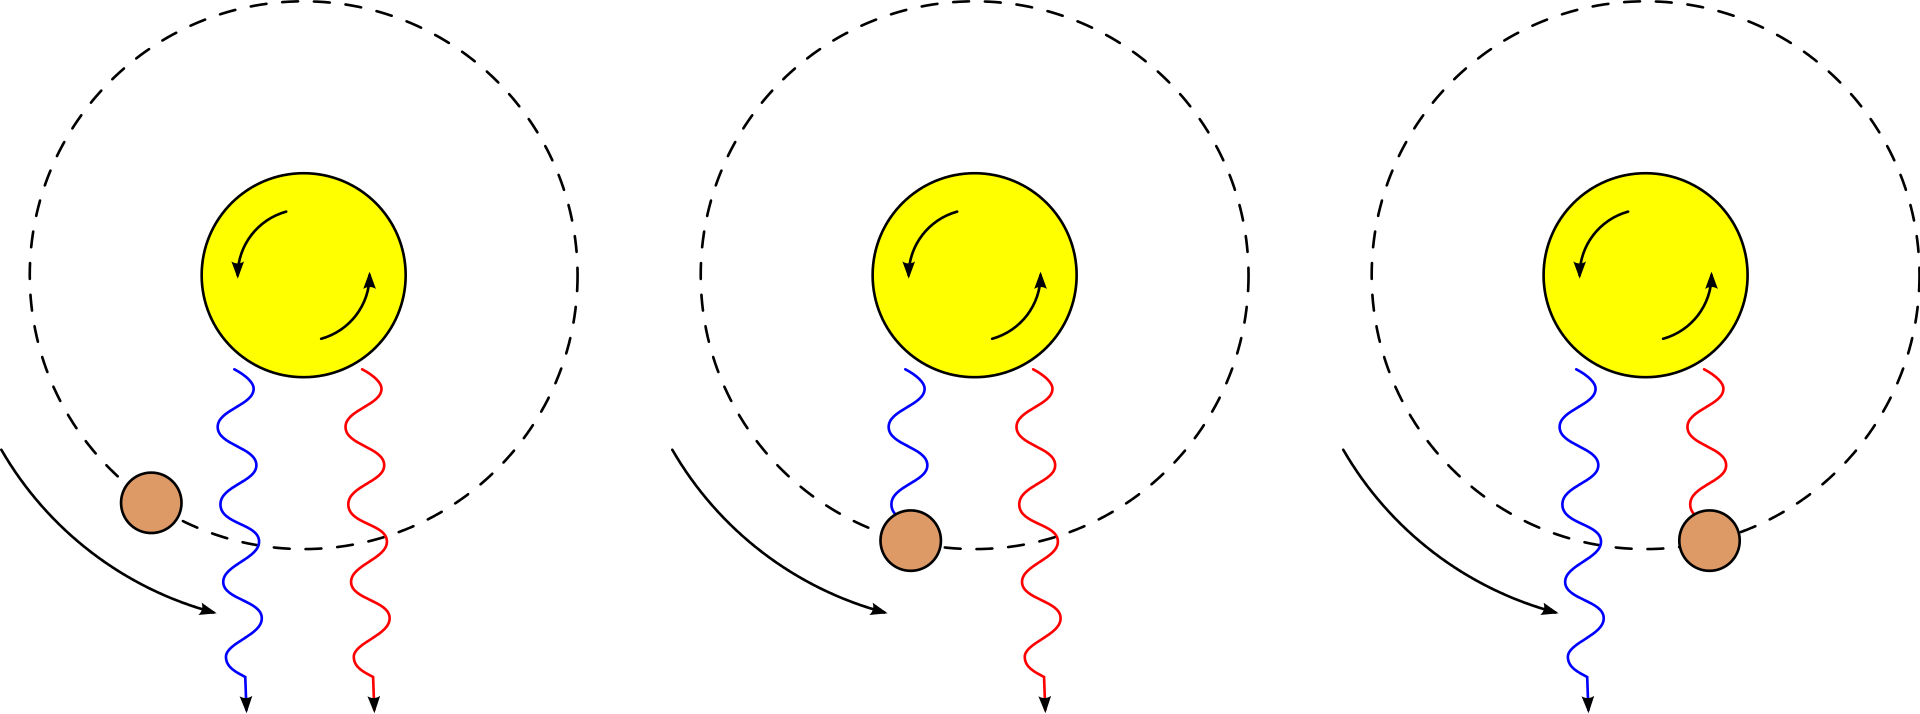

Note the [Rossiter-McLaughlin effect]('https://en.wikipedia.org/wiki/Rossiter%E2%80%93McLaughlin_effect') graphic above. As an exoplanet transits its host star, it will block redshifted or blueshifted light depending on which half of the star it is blocking. This will result in a shift in the line profile of the star. This is a key effect to correct for when analyzing line profiles of atomic species in exoplanet atmospheres, called the Doppler Shadow. Although partially corrected for in other code I've written for this research, it can still influence the line profiles and should be noted.

## Gaussian Fitting on 1D SNR Slices of red and blue arms of Fe I

In [ ]:
run_all_ccfs.make_shifted_plot = make_shifted_plot
run_all_ccfs('KELT-20b', 'inverted-transmission-better', 'Fe I', 5.39e-05, False, True, True, 'ccf')

NameError: name 'run_all_ccfs' is not defined

### Fe I Discussion

- Red arm
    - SNR peak at Kp = 194km/s, this is our horizontal slice
    - Gaussian fit
        - amplitude (SNR) = 14.08
        - center (V_sys) = -1.13 km/s
        - standard deviation = 7.26 km/s

- Blue arm
    - SNR peak at Kp = 175 km/s
    - Gaussian fit
        - amplitude (SNR) = 4.60
        - center (V_sys) = -2.70 km/s
        - standard deviation = 6.02 km/s

- Limb Asymmetry Analysis
    - The red arm has a much stronger signal than the blue arm. Additionally, the center of 	the blue arm's wind is somewhat more blueshifted, whereas the red arm is somewhat more 		broadened. In the red arm, the species becomes more blueshifted with phase, with a 			significant decrease of -2km/s at the beginning of transit to more than -6km/s at the 		conclusion.  According to [Savel et. al]('https://iopscience.iop.org/article/10.3847/1538-	  4357/acb141/meta') any of the following can cause the aforementioned features:
	  	- Escaping atmosphere: due to a blueshifting CCF with phase.
		- Scale height difference: due to a blueshifting CCF with phase.
		- Weak drag state: blueshifted CCF
		- Cold interior: blueshifted CCF
		- Day-night winds: blueshifted CCF
		- Condensation: strongly blueshifting CCF with phase
		- Tidal deformation/lag: blueshifting CCF with phase
		- T-dependent velocity: blueshifting CCF with phase
		- Clouds: blueshifted CCF

## Gaussian Fits on 1D CCF Slices of red and blue arms of Fe II

In [ ]:
run_all_ccfs('KELT-20b', 'inverted-transmission-better', 'Fe II', 5.39e-05, False, True, True, 'ccf')

NameError: name 'run_all_ccfs' is not defined

### Fe II Discussion
- Red arm
	- SNR: 22.23
	- Vsys: 0.61 km/s
	- Sigma: 4.88 km/s
	- Kp: 163 km/s

- Blue arm
	- SNR: 6.36
	- Vsys: 0.25 km/s
	- Sigma: 5.99 km/s
	- Kp: 150 km/s

- Limb asymmetry analysis
	- The signal from the red arm is again stronger than the blue. Their V_sys's are 			similar, both being near-zero. The blue arm has greater broadening. The red 			  arm becomes steadily less blueshifted with phase.
	- The phase asymmetries are largely negligible for this species. The only significant difference is with signal strength.
		

## Gaussian Fits on 1D CCF Slices of red and blue arms of Ni I

In [ ]:
run_all_ccfs('KELT-20b', 'inverted-transmission-better', 'Ni I', 2.67e-06, False, True, True, 'ccf')

NameError: name 'run_all_ccfs' is not defined

### Ni I Discussion
- Red arm
	- SNR: 2.94
	- Vsys: 0.07 km/s
	- Sigma: 4.33 km/s
	- Kp: 98
	
- Blue arm
	- SNR: 3.98
	- Vsys: -5.08 km/s
	- Sigma: 2.76 km/s
	- Kp: 254
- Limb asymmetry analysis
	- Only the blue arm just barely meets the threshold for detection, as signified by the horizontal dashed green like a 4 SNR. Since this is the case, I will be considering the parameters of the blue arm Gaussian with more weight
	- The blue arm Vsys center is at -5k/s, with little variation besides a short deviation in the observation between orbital phase -0.01 and -0.005. 
	- Possible causes of observed feautres, which are all due to blueshifted CCF:
		- Weak drag state
		- Cold interior
		- Day-night winds
		- Clouds



## Gaussian Fits of 1D Slices of red and blue arms of V I

In [ ]:
run_all_ccfs('KELT-20b', 'inverted-transmission-better', 'V I', 5.632e-09, False, True, True, 'ccf')

NameError: name 'run_all_ccfs' is not defined

### V I Discussion

- Red arm
	- SNR: 2.79
	- Vsys: -3.21 km/s
	- Sigma: 2.68 km/s
	- Kp: 211
		
- Blue arm
	- SNR: 1.39
	- Vsys: -5.50 km/s
	- Sigma: 2.68 km/s
	- Kp: 269
		
		
- As an example, I threw in a nondetection here. At no point does Vanadium reach the 4-sigma threshold for signal detection. Although the Gaussian fit parameters are realistic,  the Vsys/sigma vs orbital phase shows erratic features.


## Gaussian fits of 1D slices of red and blue arms of Ca I

In [ ]:
run_all_ccfs('KELT-20b', 'inverted-transmission-better', 'Ca I', 2.101e-08, False, True, True, 'ccf')

NameError: name 'run_all_ccfs' is not defined

### Ca I Discussion
- Red arm
	- SNR: 3.42
	- Vsys: 0.59 km/s
	- Sigma: 4.61 km/s
	- Kp: 131

- Blue arm
	- SNR: 4.44
	- Vsys: 0.47 km/s
	- Sigma: 4.62 km/s
	- Kp: 167

- Limb Asymmetry analysis
	- The blue arm is beyond the detection threshold, whereas the red arm is close, but does not meet, the detection threshold. Both Vsys's are near-zero and barely vary. Additionally, their sigmas are virtually equal. This detection is a good example of one that possesses very few assymmetries, with one caveat: In both arms, there is a strong shift in the Vsys/Sigma vs orbital phase curves around the 0.015 phase mark, leading me to believe there was an error in observation during this time.

### Conclusions

I have successfully fit gaussian profiles to the line profiles of several atomic species in KELT-20b's atmosphere. I have also analyzed the derived parameters and described all important takeaways for each species. Using Savel et al. as a reference, I've determined which atmospheric dynamics would be causing the limb asymmetries. Originally, I claimed that in this notebook I could quantitatively determine which of these mechanics are resulting in the plot's features, but that has proven to be a much too involved task for the scope of this notebook and time constraints I have to work in. I intend to continue working on diagnosing the mechanisms as a part of my research. Overall, this notebook was a success! Several of these visualizations will be employed when presenting my poster at the AAS meeting.

## MCMC Removal of Doppler Shadow

In [ ]:
def DopplerShadowModel(vsini, 
                        lambda_p, 
                        drv, 
                        planet_name, 
                        exptime,
                        orbital_phase,
                        obs,
                        inputs = {
                                    'mode':'spec',  
                                    'res':'medium', 
                                    'resnum': 0,    
                                    'onespec':'n',
                                    'convol':'n',
                                    'macroturb':'n',
                                    'diffrot':'n',
                                    'gravd':'n',
                                    'image':'n',
                                    'path':'y',
                                    'amode':'a',
                                    'emode':'simple',
                                    'lineshifts':'y',
                                    'starspot': False
                                    }
                        ):
        """
        Inputs: vsini - the projected rotational velocity (km/s)
                lambda_p - the spin-orbit misalignment (degrees)
                drv -  array containing the velocities at which the line profile will be calculated, in km/s, double check this
                planet_name - string containing the planet name
                exptime -  
                oribital_phase - 
                obs - string containing the observatory name
                inputs - dictionary containing the optional parameters

        """
        #add translation in the function from horus for obsnam
                #ex: if obsname = , then obsname =  pepsi/lbt
        if obs == 'keck' : Resolve=50000.0
        if obs == 'hjst' : Resolve=60000.0
        if obs == 'het' : Resolve=30000.0
        if obs == 'keck-lsi' : Resolve=20000.0
        if obs == 'subaru' : Resolve=80000.0
        if obs == 'aat' : Resolve=70000.0
        if obs == 'not' : Resolve=47000.0
        if obs == 'tres' : Resolve=44000.0
        if obs == 'harpsn' : Resolve=120000.0
        if obs == 'lbt' or obs == 'pepsi' : Resolve=120000.0
        if obs == 'igrins': Resolve=40000.0
        if obs == 'nres': Resolve=48000.0
        
        
        #get planetary parameters
        Period, epoch, M_star, RV_abs, i, M_p, R_p, RA, Dec, Kp_expected, half_duration_phase = get_planet_parameters(planet_name)
        # put into horus struc

        struc = {
                'vsini': vsini,
                'width':3.0,    # hardcoded  
                'gamma1':0.2, # linear limb-darkening coefficient, hardcoded
                'gamma2':0.2, # quadratic limb-darkening coefficient, hardcoded
                'vabsfine': drv,  # array containing the velocities at which the line profile will be calculated, in km/s, double check this
                'obs': obs,   # name of an observatory or spectrograph
                'sysname':'test',   # hardcoded
                'lineshifts':'y',   # hardcoded

                # Required for Doppler tomographic model
                'Pd':Period.n,    # Planetary orbital period (days)
                'lambda':lambda_p,  # spin-orbit misalignment (deg)
                'b':0.503,       # transit impact parameter, hardcoded
                'rplanet': 0.11440, # the Rp/Rstar value for the transit. hardcoded
                't':orbital_phase * Period.n * 24*60 
                , # minutes since center of transit
                'times': np.float64(exptime) * 1/60,    # exposure time (in minutes), array length must match 't'    
                'a': 7.466,     # scaled semimajor axis of the orbit, a/Rstar, hardcoded?
                'dur': half_duration_phase*2*Period.n, # duration of transit (days), optional?
                'e': 0.0,     # 
                'periarg': 90.0,   #  (deg)
                # Required for macroturbulence
                'zeta': 2.0,    # the macroturbulent velocity dispersion (km/s)

                # Required for differential rotation
                'inc': 25.0,    # the inclination of the stellar rotation axis wrt the line of sight (deg)
                'alpha': 0.1,   # differential rotation parameter
                
                # Required for gravity darkening
                #'inc':         # already used in differential rotation, comment out otherwise
                'beta': 0.1,    # gravity darkening parameter
                'Omega':7.27e-5,# stellar rotation rate (rad/s)
                'logg': 4.292,  # stellar logg
                'rstar': 1.561, # called Reqcm in docs, stellar radius (solar radii)
                'f': 1.0    ,
                'psi': 5.0      # doesn't say in docs to input this
                }
        

        # call horus
        model = horus.model(
        struc,
        inputs['mode'],
        inputs['convol'],
        inputs['gravd'],
        inputs['res'],
        inputs['resnum'],
        inputs['image'],
        inputs['onespec'],
        inputs['diffrot'],
        inputs['macroturb'],
        inputs['emode'],
        inputs['amode'],
        inputs['path'],
        inputs['lineshifts'],
        inputs['starspot']
        )

        
        # check if the below loops are even necessary
        if inputs['mode'] == 'spec':
            if inputs['onespec'] != 'y':
                profarr = model['profarr']
                basearr = model['basearr']
                baseline = model['baseline']
                z1 = model['z1']
                z2 = model['z2']    

        ccf_model = np.matrix(profarr-basearr)
       
        return ccf_model


## Asymmetry Metric

## Volume Mixing Ratio plot Using FastChem

## CCF vs phase for 3 different phase bins:
- no ingress/egress
- full transit 
- only ingress/egress

##### Phase bin 1: no ingress/egress

## Planet-frame Doppler shift by species

## Vsys versus phase for several species overlaid

## Comparing Doppler shadow removal for different orbital and physical parameters of KELT-20b

##### Old params

In [ ]:
def get_planet_parameters(planet_name):

    MJoMS = 1./1047. #MJ in MSun

    if planet_name == 'KELT-20b':
        #For KELT-20 b:, from Lund et al. 2018
        Period = ufloat(3.4741085, 0.0000019) #days
        epoch = ufloat(2457503.120049, 0.000190) #BJD_TDB

        M_star = ufloat(1.76, 0.19) #MSun
        RV_abs = ufloat(0.0, 0.0) #km/s
        i = ufloat(86.12, 0.28) #degrees
        M_p = 3.382 #3-sigma limit
        R_p = 1.741

        RA = '19h38m38.74s'
        Dec = '+31d13m09.12s'

        dur = 3.755/24. #hours -> days
        
        #add vsini, lambda, spin-orbit-misalignment,any other horus params

    half_duration_phase = (dur/2.)/Period.n
    Kp_expected = 28.4329 * M_star/MJoMS * unp.sin(i*np.pi/180.) * (M_star + M_p * MJoMS) ** (-2./3.) * (Period/365.25) ** (-1./3.) / 1000. #to km/s
    half_duration_phase = (dur/2.)/Period.n

    return Period, epoch, M_star, RV_abs, i, M_p, R_p, RA, Dec, Kp_expected, half_duration_phase #add other outputs!!

In [ ]:
run_all_ccfs.get_planet_parameters = get_planet_parameters
run_all_ccfs('KELT-20b', 'inverted-transmission-better', 'Fe I', 5.39e-05, False, True, True, 'ccf')

NameError: name 'run_all_ccfs' is not defined

##### New params

In [ ]:
def get_planet_parameters(planet_name):

    MJoMS = 1./1047. #MJ in MSun

    if planet_name == 'KELT-20b':
        #For KELT-20 b:, from Lund et al. 2018
        Per = ufloat(3.47410055, 0.00000024)
        epoch = ufloat(2459420.823308, 0.000023)

        M_star = ufloat(1.76, 0.19) #MSun
        RV_abs = ufloat(0.0, 0.0) #km/s
        i = ufloat(86.12, 0.28) #degrees
        M_p = 3.382 #3-sigma limit
        R_p = 1.741

        RA = '19h38m38.74s'
        Dec = '+31d13m09.12s'

        dur = 3.755/24. #hours -> days
        
        #add vsini, lambda, spin-orbit-misalignment,any other horus params  

    half_duration_phase = (dur/2.)/Period.n
    Kp_expected = 28.4329 * M_star/MJoMS * unp.sin(i*np.pi/180.) * (M_star + M_p * MJoMS) ** (-2./3.) * (Period/365.25) ** (-1./3.) / 1000. #to km/s
    half_duration_phase = (dur/2.)/Period.n

    return Period, epoch, M_star, RV_abs, i, M_p, R_p, RA, Dec, Kp_expected, half_duration_phase #add other outputs!!
    

In [ ]:
run_all_ccfs.get_planet_parameters = get_planet_parameters
run_all_ccfs('KELT-20b', 'inverted-transmission-better', 'Fe I', 5.39e-05, False, True, True, 'ccf')

NameError: name 'run_all_ccfs' is not defined

##### Overlaying V_sys line profile over phase duration for all detected species

In [ ]:
def gaussian_fit_extractor(Kp, Kp_true, drv, species_label, planet_name, observation_epoch, arm, species_name_ccf, model_tag, plotsnr):
    """
    Extracts Gaussian fit parameters from the 1D slice during transit.

    Parameters:
    - Same as before

    Returns:
    - centers (array): Array of center values from Gaussian fits.
    - centers_err (array): Array of errors for center values.
    - sigmas (array): Array of sigma values from Gaussian fits.
    - sigmas_err (array): Array of errors for sigma values.
    """


    if arm == 'red' or arm == 'blue':   
        # Fitting a Gaussian to the 1D slice during transit

        # Initializing lists to store fit parameters
        amps = []
        amps_err = []
        centers = []
        centers_err = []
        sigmas = []
        sigmas_err = []

        Kp_slices = []
        Kp_slice_peak = []

        residuals = []
        chi2_red = []

        # Fitting gaussian to all 1D Kp slices
        for i in range(plotsnr.shape[0]):
            current_slice = plotsnr[i,:]
            Kp_slices.append(current_slice)
            Kp_slice_peak.append(np.max(current_slice[80:121]))


            popt, pcov = curve_fit(gaussian, drv, current_slice, p0=[5, -7, 1])

            amps.append(popt[0])
            centers.append(popt[1])
            sigmas.append(popt[2])

            # Storing errors (standard deviations)
            amps_err.append(np.sqrt(pcov[0, 0]))
            centers_err.append(np.sqrt(pcov[1, 1]))
            sigmas_err.append(np.sqrt(pcov[2, 2]))

        amps, amps_err = np.array(amps), np.array(amps_err)
        centers, centers_err = np.array(centers), np.array(centers_err)
        sigmas, sigmas_err = np.array(sigmas), np.array(sigmas_err)

        Kp_slices = np.array(Kp_slices)
        Kp_slice_peak = np.array(Kp_slice_peak)

        residuals = np.array(residuals)
        chi2_red = np.array(chi2_red)

        # Selecting a specific Kp slice
        selected_idx = np.where(Kp == int((np.floor(Kp_true))))[0][0] #Kp slice corresponding to expected Kp
        selected_idx = np.argmax(Kp_slice_peak)                       #Kp slice corresponding to max SNR
        
        # Fitting a Gaussian to the selected slice
        popt_selected = [amps[selected_idx], centers[selected_idx], sigmas[selected_idx]]
        print('Selected SNR:', amps[selected_idx], '\n Selected Vsys:', centers[selected_idx], '\n Selected sigma:', sigmas[selected_idx], '\n Selected Kp:', Kp[selected_idx])
    
        # Computing residuals and chi-squared for selected slice
        residual = plotsnr[selected_idx, :] - gaussian(drv, *popt_selected)
        # chi2 = np.sum((residual / np.std(residual))**2)/(len(drv)-len(popt))

        # Initialize Figure and GridSpec objects
        fig = pl.figure(figsize=(12,8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])

        # Create Axes for the main plot and the residuals plot
        ax1 = pl.subplot(gs[0])
        ax2 = pl.subplot(gs[1], sharex=ax1)
        
        # Main Plot (ax1)
        ax1.plot(drv, plotsnr[selected_idx, :], 'k--', label='data', markersize=2)
        ax1.plot(drv, gaussian(drv, *popt_selected), 'r-', label='fit')

        # Species Label
        ax1.text(0.05, 0.99, species_label, transform=ax1.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)

        pl.setp(ax1.get_xticklabels(), visible=False)
        ax1.set_ylabel('SNR')
        # Annotating the arm and species on the plot
        
        # Additional text information for the main plot
        params_str = f"Peak (a): {popt_selected[0]:.2f}\nMean (mu): {popt_selected[1]:.2f}\nSigma: {popt_selected[2]:.2f}\nKp: {Kp[selected_idx]:.0f}"
        ax1.text(0.01, 0.95, params_str, transform=ax1.transAxes, verticalalignment='top', fontsize=10)

        arm_species_text = f'Arm: {arm}'
        ax1.text(0.15, 0.95, arm_species_text, transform=ax1.transAxes, verticalalignment='top', fontsize=10)
        
        # Vertical line for the Gaussian peak center
        ax1.axvline(x=centers[selected_idx], color='b', linestyle='-', label='Center')
        ax1.set_title('1D CCF Slice + Gaussian Fit')


        # Vertical lines for sigma width (center ± sigma)
        #sigma_left = centers[selected_idx] - sigmas[selected_idx]
        #sigma_right = centers[selected_idx] + sigmas[selected_idx]
        #ax1.axvline(x=sigma_left, color='purple', linestyle='--', label='- Sigma')
        #ax1.axvline(x=sigma_right, color='purple', linestyle='--', label='+ Sigma')

        ax1.legend()

        # Add the horizontal line at 4 SNR
        ax1.axhline(y=4, color='g', linestyle='--', label=r'4 $\sigma$')    

        # Inset for residuals (ax2)
        ax2.plot(drv, residual, 'o-', markersize=1)
        ax2.set_xlabel('Velocity (km/s)')
        ax2.set_ylabel('Residuals')


       
        
        # Consider a clearer naming scheme
        snr_fit = '/home/calder/Documents/atmo-analysis-main/plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.SNR-Gaussian.pdf'
        # Save the plot
        fig.savefig(snr_fit, dpi=300, bbox_inches='tight')

        if arm == 'red':
            do_molecfit = True
        else:
            do_molecfit = False

        Period, epoch, M_star, RV_abs, i, M_p, R_p, RA, Dec, Kp_expected, half_duration_phase = get_planet_parameters(planet_name)

        wave, fluxin, errorin, jd, snr_spectra, exptime, airmass, n_spectra, npix = get_pepsi_data(arm, observation_epoch, planet_name, do_molecfit)

        orbital_phase = get_orbital_phase(jd, epoch, Period, RA, Dec)

        phase_min = np.min(orbital_phase)
        phase_max = np.max(orbital_phase)
        phase_array = np.linspace(phase_min, phase_max, np.shape(centers)[0])

        fig, ax1 = pl.subplots(figsize=(12,8))

        ax1.text(0.05, 0.99, species_label, transform=ax1.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)


        ax1.plot(phase_array, centers, 'o-', label='Center')
        ax1.fill_between(phase_array, centers - centers_err, centers + centers_err, color='blue', alpha=0.2)
        ax1.set_xlabel('Orbital Phase')
        ax1.set_ylabel('Vsys', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        ax1.set_title('Vsys and Sigma vs. Orbital Phase')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.plot(phase_array, sigmas, 'r-', label='Sigma')
        ax2.fill_between(phase_array, sigmas - sigmas_err, sigmas + sigmas_err, color='red', alpha=0.2)

        ax2.set_ylabel('Sigma', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        ax2.legend(loc='upper right')


        # Consider a clearer naming scheme
        wind_chars = '/home/calder/Documents/atmo-analysis-main/plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.Wind-characteristics.pdf'
        # Save the plot
        fig.savefig(wind_chars, dpi=300, bbox_inches='tight')

        return centers, centers_err, phase_array

run_all_ccfs.gaussian_fit = gaussian_fit_extractor

NameError: name 'run_all_ccfs' is not defined

In [ ]:
def make_shifted_plot(snr, planet_name, observation_epoch, arm, species_name_ccf, model_tag, RV_abs, Kp_expected, V_sys_true, Kp_true, do_inject_model, do_combine, drv, Kp, species_label, temperature_profile, method, plotformat='pdf'):
    """
    Creates a shifted plot of the CCFs or likelihoods for a given planet, observation epoch, arm, and species.

    Args:
    snr (numpy.ndarray): Signal-to-noise ratio of the CCFs or likelihoods.
    planet_name (str): Name of the planet.
    observation_epoch (str): Observation epoch.
    arm (str): Spectrograph arm.
    species_name_ccf (str): Name of the species.
    model_tag (str): Model tag.
    RV_abs (astropy.units.Quantity): Absolute radial velocity.
    Kp_expected (astropy.units.Quantity): Expected Kp.
    V_sys_true (astropy.units.Quantity): True systemic velocity.
    Kp_true (astropy.units.Quantity): True Kp.
    do_inject_model (bool): Whether to inject the model.
    do_combine (bool): Whether to combine the plots.
    drv (astropy.units.Quantity): Radial velocity.
    Kp (astropy.units.Quantity): Kp.
    species_label (str): Species label.
    temperature_profile (str): Temperature profile.
    method (str): Method used to create the plot (either 'ccf' or 'likelihood').
    plotformat (str): Format of the plot file (default is 'pdf').

    Returns:
    None
    """

    if method == 'ccf':
        outtag, zlabel = 'CCFs-shifted', 'SNR'
        plotsnr = snr[:]
    if 'likelihood' in method:
        outtag, zlabel = 'likelihood-shifted', '$\Delta\ln \mathcal{L}$'
        plotsnr=snr - np.max(snr)
    plotname = '/home/calder/Documents/atmo-analysis-main/plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.' + outtag + '.' + plotformat

    if do_combine:
        plotname = '/home/calder/Documents/atmo-analysis-main/plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.' + outtag + '.' + plotformat

    if not do_inject_model:
        apoints = [unp.nominal_values(RV_abs), unp.nominal_values(Kp_expected)]
    else:
        apoints = [V_sys_true, Kp_true]

    if do_inject_model:
        model_label = 'injected'
    else:
        model_label = ''

    if 'transmission' in temperature_profile:
        ctable = 'bone'
    else:
        ctable = 'afmhot'

    keeprv = np.abs(drv-apoints[0]) <= 100.
    plotsnr, drv = plotsnr[:, keeprv], drv[keeprv]
    keepKp = np.abs(Kp-apoints[1]) <= 100.
    plotsnr, Kp = plotsnr[keepKp, :], Kp[keepKp]

    # Fit a Gaussian to the line profile
    gaussian_fit(Kp, Kp_true, drv, species_label, planet_name, observation_epoch, arm, species_name_ccf, model_tag, plotsnr)

    psarr(plotsnr, drv, Kp, '$V_{\mathrm{sys}}$ (km/s)', '$K_p$ (km/s)', zlabel, filename=plotname, ctable=ctable, alines=True, apoints=apoints, acolor='cyan', textstr=species_label+' '+model_label, textloc = np.array([apoints[0]-75.,apoints[1]+75.]), textcolor='cyan', fileformat=plotformat)

    return plotsnr, Kp    
run_all_ccfs.make_shifted_plot = make_shifted_plot

NameError: name 'run_all_ccfs' is not defined

In [ ]:
def plot_species_vsys(planet_name, temperature_profile, species_dict, do_inject_model, do_run_all, do_make_new_model, method):

    """
    Plots Vsys and Sigma vs. Orbital Phase for multiple species.

    Args:
    planet_name (str): Name of the planet.
    temperature_profile (str): Type of temperature profile
    species_dict (dict): Dictionary containing the species to analyze with corresponding VMRs.

    """
    species_values = {}  # Dictionary to store extracted values


    snr, Kp, drv = combine_ccfs(drv, cross_cor, sigma_cross_cor, orbital_phase, len(orbital_phase), ccf_weights, half_duration_phase, temperature_profile)
    Period, epoch, M_star, RV_abs, i, M_p, R_p, RA, Dec, Kp_expected, half_duration_phase = get_planet_parameters(planet_name)
    Kp_true = combine_observations(observation_epochs, arms, planet_name, temperature_profile, species_label, species_name_ccf, model_tag, RV_abs, Kp_expected, do_inject_model, f, method)

    for species_label, vmr in species_dict.items():
        # Run the CCF analysis for each species
        run_all_ccfs(planet_name, temperature_profile, species_label, vmr, do_inject_model, do_run_all, do_make_new_model, method)

        # Extract centers, centers_err, and phase_array
        centers, centers_err, phase_array = gaussian_fit_extractor(Kp, Kp_true, drv, species_label, planet_name, observation_epoch, arm, species_label, model_tag, plotsnr)

        # Store the extracted values
        species_values[species_label] = (centers, centers_err, phase_array)

    initial_time=time.time()
    ckms = 2.9979e5

    instrument = 'PEPSI'

    if do_inject_model:
        model_tag = '.injected-'+str(vmr)
    else:
        model_tag = ''

    if 'transmission' in temperature_profile:
        spectrum_type = 'transmission'
        if planet_name == 'KELT-20b': observation_epochs = ['20190504']
    else:
        spectrum_type = 'emission'
        if planet_name == 'KELT-20b': observation_epochs = ['20210501', '20210518']
        if planet_name == 'WASP-12b': observation_epochs = ['20210303', '20220208']
        if planet_name == 'KELT-9b': observation_epochs = ['20210628']
        if planet_name == 'WASP-76b': observation_epochs = ['20211031']
        if planet_name == 'WASP-33b': observation_epochs = ['20220929', '20221202']
        if planet_name == 'WASP-189b': observation_epochs = ['20230327']


    if species_label == 'FeH':
        arms = ['red']
    elif species_label == 'CaH':
        arms = ['blue']
    else:
        arms = ['blue','red']
            
    species_name_inject, species_name_ccf = get_species_keys(species_label)

    file_out = '/home/calder/Documents/atmo-analysis-main/logs/'+ planet_name + '.' + species_name_ccf + model_tag + '.log' #edited for my own machine
    f = open(file_out,'w')

    f.write('Log file for ' + planet_name + ' for ' + species_name_ccf + ' \n')

    if do_make_new_model:
        template_wave, template_flux = make_new_model(instrument, species_name_ccf, vmr, spectrum_type, planet_name, temperature_profile, do_plot=True)
    else:
        template_wave, template_flux = get_atmospheric_model(planet_name, species_name_ccf, vmr, temperature_profile, True, True)

    if species_name_ccf != species_name_inject:
        if do_make_new_model:
            template_wave_in, template_flux_in = make_new_model(instrument, species_name_inject, vmr, spectrum_type, planet_name, temperature_profile)
        else:
            template_wave_in, template_flux_in = get_atmospheric_model(planet_name, species_name_inject, vmr, temperature_profile, True, True)
    else:
        template_wave_in, template_flux_in = template_wave, template_flux

    if do_run_all:
        for observation_epoch in observation_epochs:
            for arm in arms:
                print('Now running the ',arm,' data for ',observation_epoch)
                run_one_ccf(species_label, vmr, arm, observation_epoch, template_wave, template_flux, template_wave_in, template_flux_in, planet_name, temperature_profile, do_inject_model, species_name_ccf, model_tag, f, method, do_make_new_model)

    print('Now combining all of the data')




    # Plotting
    fig, ax = pl.subplots(figsize=(12, 8))

    for species_label, (centers, centers_err, phase_array) in species_values.items():
        ax.errorbar(phase_array, centers, yerr=centers_err, label=species_label)

    ax.set_xlabel('Orbital Phase')
    ax.set_ylabel('Vsys')
    ax.legend()
    pl.title('Vsys vs. Orbital Phase for Multiple Species')
    pl.show()


In [ ]:
# Example usage
#species_dict = {'Fe I': 5.39e-05, 'Fe II': 5.39e-05, 'Ni I': 2.67e-06, 'V I': 5.632e-09, 'Ca I': 2.101e-08}
species_dict = {'Fe I': 5.39e-05, 'Fe II': 5.39e-05}
plot_species_vsys('KELT-20b', 'inverted-transmission-better', species_dict, 'red', 'inverted-transmission-better', False, 'ccf')

NameError: name 'combine_ccfs' is not defined

In [ ]:
def phase_bin(orbital_phase)):

    """
    Separates the orbital phases into bins: ingress, in-transit, egress, and out-of-transit.
    """
    if planet_name = 'KELT-20b':
        # ingress/egress phases, get more precise values later
        ingress_start = -0.02
        ingress_end = 0.02
        in_transit = (normalized_phase >= ingress_start) & (normalized_phase <= egress_end)
        out_transit = (normalized_phase < ingress_start) | (normalized_phase > egress_end)

        return in_transit, out_transit